# Mall Customer Segmentation Data

## Objective
You are owning a supermarket mall and want to understand the customers to develop a marketing strategy.
You have information from customer membership cards, such as Customer ID, Age, Gender, Annual Income and a Spending Score, which is a score assigned to the customer based on parameters like customer behaviour and purchasing data. 


The source of the dataset is [here](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python).


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline

In [2]:
#Import modelling libraries

#K-Means Clustering
from sklearn.cluster import KMeans

#Agglomeration Clustering 
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

#DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#3D Plotting
from mpl_toolkits.mplot3d import axes3d

## Load Data

In [3]:
#Load files into a Pandas dataframe
def load_file(df): 
    return pd.read_csv(df)

In [4]:
#Load and define data
data = load_file('Mall_Customers.csv')

## Data Cleaning

In [5]:
#Check data is DataFrame
type(data)

pandas.core.frame.DataFrame

In [6]:
#Preview data
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
#Check shape of data
data.shape

(200, 5)

In [8]:
#Check data types and missing data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Appears to show no missing data and appropriate data types.

In [9]:
#Confirm check of no missing values
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [10]:
#Descriptive stats for integer and float variables 
#Only integer variables in data; no float variables in data
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [11]:
#Descriptive stats for object variables 
data.describe(include='object')

,Gender
count,200
unique,2
top,Female
freq,112


No indication of invalid data from both descriptive stats above. 

In [12]:
#Check if CustomerID has no duplicates
data['CustomerID'].is_unique

True

Returning 'True' indicates no duplicates in CustomerID. 

No missing data, duplicates nor invalid data in the dataset before proceeeding to Exploratory Data Analysis and Modelling.

# Exploratory Data Analysis

In [13]:
#Define features as data without CustomerID 
#features is used for EDA
features = data.drop('CustomerID',axis=1)

In [14]:
features

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


In [15]:
type(features)

pandas.core.frame.DataFrame

In [16]:
features['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

In [17]:
features['Gender'].value_counts(sort=False)

Male       88
Female    112
Name: Gender, dtype: int64

In [18]:
features['Gender'].dtype

dtype('O')

In [19]:
features.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [20]:
features.columns = ['Gender', 'Age', 'Income', 'Score']

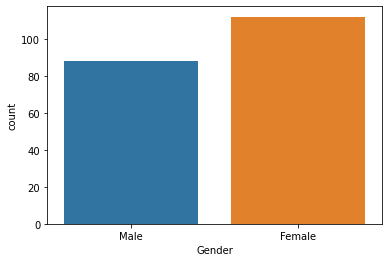

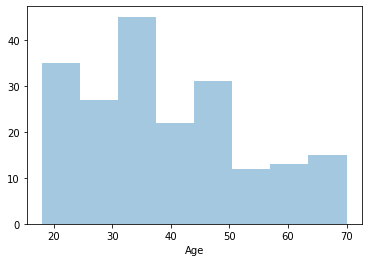

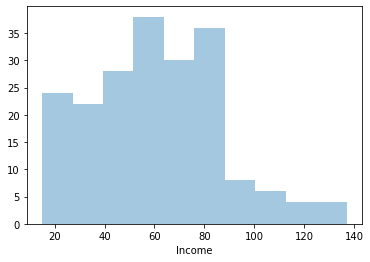

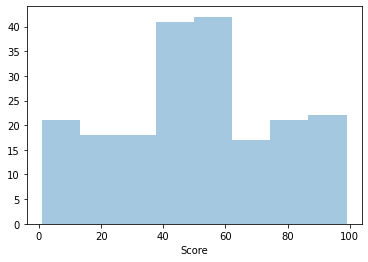

In [21]:
for i in features.columns: 
    if features[i].dtype == 'O':
        sns.countplot(features[i])
    else:
        sns.distplot(features[i],kde=None)
    
    plt.savefig('features_'+i)    
    plt.show()

Findings: 
* More females than males in the dataset
* Mainly below 50 years of age 
* Mainly earning less than $90k in annual income
* Greater majority with a spending score between 40 and 60, followed by upper and lower ends of the scoring spectrum. 

<Figure size 3600x3600 with 0 Axes>

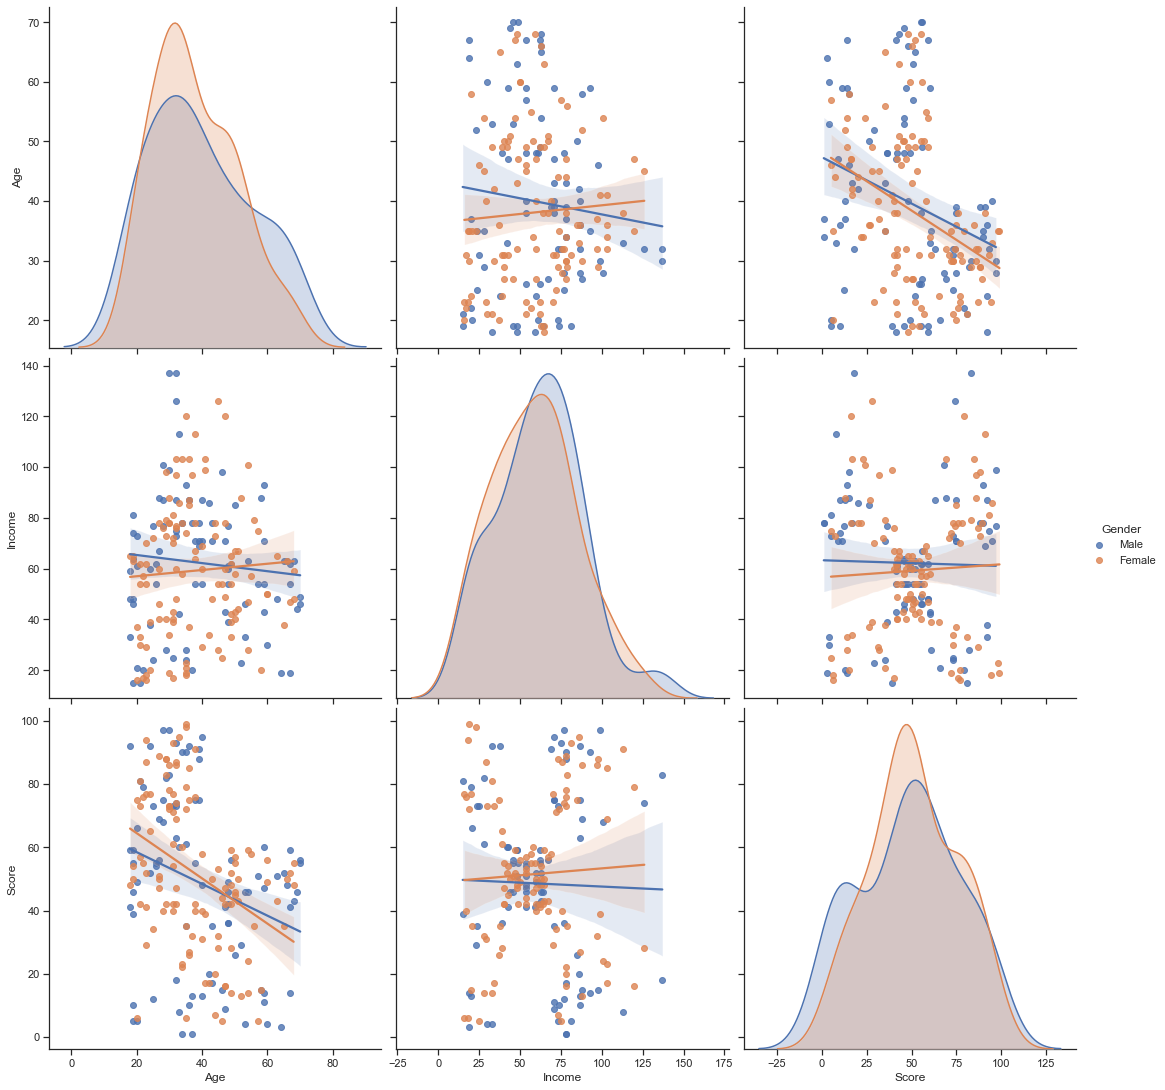

In [22]:
#Pairplots
plt.figure(figsize=(50,50))
sns.set(style="ticks")
sns.pairplot(features, hue='Gender',kind='reg',height = 5)
plt.savefig('Pairplots')
plt.show()

**Distributions** 
* Greater kurtosis of Females distributions for Age and Spending Score (1-100) than Males.
* Both Genders have similar Annual Income distributions.
* Both Genders have more spending scores roughly around 50.  
* Both Genders have two peaks in their distributions of Spending Scores: 
    * Males have one peak of low Spending Scores and another slightly above 50;
    * Females mostly have a Spending Score of 50 and another slight peak in the higher end of the Spending Scores. 

**Linear regressions and scatter plots** 
* No significant differences between Genders in terms of the relationships against each feature.
* No evident relationship between Age and Annual Income, but noticed that the younger and older ends of the age distribution have lower distribution and lower spread in Annual Income, while there is a greater spread and broader distribution of Annual Income for more middle-aged individuals. 
* The most significant correlation in terms of magnitude is the negative correlation between Spending Score and Age. 
* Possible clusters appear between Age and Spending Score, and for Spending Score and Annual Income. 

**Hypothesis of clustering**
* Potentially 5 clusters in the Annual Income and Spending Score scatter plots (see middle right and bottom middle plots).
* Between Age and Spending Scores, there could be 3 bins or clusters: (see bottom left plot)
    * 1. Aged between roughly 20 and below 50 with 60+ Spending Scores
    * 2. Majority across all ages between 20 to 60 in Spending Scores
    * 3. Spending Scores below 20. 

In [23]:
#Drop Gender variable 
features = features.drop('Gender',axis=1)
features.head()

,Age,Income,Score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


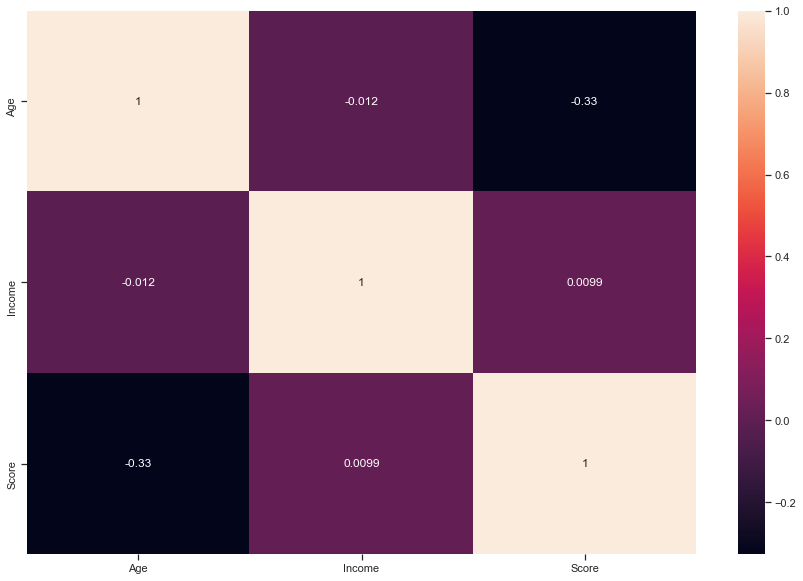

In [24]:
#Correlation heatmap
fig, axes = plt.subplots(figsize=(15, 10)) 
sns.heatmap(features.corr(),annot=True)
plt.savefig('corr_heatmap')
plt.show()

Only the negative correlation between age and spending score is significant, as shown earlier.

## Modelling

K-Means Clustering, Agglomerative Clustering and DBSCAN were models to cluster the individuals differently. Each model has its own approach to test parameters in selecting an appropriate model.  
* Inertia is calculated to find the elbow point, where the number of clusters is selected
* Dendrograms help with selecting the number of clusters and appropriate linkage method for Agglomerative Clustering
* The optimal epsilon value is  used for DBSCAN is based on finding the maximum curvature on a plot of the closest distances of each point to another point. 

Scatter plots and 3D plots (as 'Females' does not a play a significant factor in clustering) are shown to provide insights of the clustering results from each model. 

In [25]:
#Create all combinations of variables for scatter plots 
from itertools import combinations
var_combos = combinations(features.columns,2)
var_combos = list(var_combos)

In [26]:
#All six combinations of scatter plots 
var_combos

[('Age', 'Income'), ('Age', 'Score'), ('Income', 'Score')]

### K-Means Clustering

In [27]:
#K-Means Clustering
labels = []
n_clusters = range(1,16)
inertia = []
features_k_means = features.copy()

for i in n_clusters:
    k_means = KMeans(init = "k-means++", n_clusters = i)
    k_means.fit(features_k_means)
    labels = k_means.labels_
    features_k_means[[i]]=pd.DataFrame(labels)
    inertia.append(k_means.inertia_)

In [28]:
#Preview features_k_means
features_k_means.head()

,Age,Income,Score,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,19,15,39,0,1,2,3,0,5,3,5,7,7,9,5,4,7,4
1,21,15,81,0,0,2,3,3,3,4,6,2,1,5,8,3,6,2
2,20,16,6,0,1,2,2,0,5,3,5,3,5,4,4,4,4,14
3,23,16,77,0,0,2,3,3,3,4,6,2,1,5,8,3,6,2
4,31,17,40,0,1,2,2,0,5,3,5,7,7,9,5,4,7,4


In [29]:
#View inertia for each 'number of clusters'
inertia

[308812.7800000001,
 212840.16982097193,
 143371.5483196735,
 104382.31574127628,
 75375.93822587247,
 58351.93915207594,
 51150.41200064303,
 44456.19886302991,
 40803.14870060973,
 37813.159868461495,
 34951.64141012245,
 33811.0944672505,
 31351.410599729134,
 29403.61468253969,
 28198.797035480864]

In [30]:
#Create inertia1 as a dataframe copy of inertia
inertia1 = pd.DataFrame(inertia.copy())

In [31]:
#Create inertia2 as a dataframe copy of inertia1 that will be updated below
inertia2 = inertia1.copy()
inertia2.columns = ['inertia']

In [32]:
#Calculate differences in inertias
inertia2[['diff']]=inertia1.diff()

In [33]:
#Calculate percentage changes of inertias
inertia2[['pct_change']] = inertia1.pct_change()

In [34]:
#Set index as the number of clusters from 1 to 15
inertia2.index = range(1,16)

In [35]:
#View dataframe containing total inertia value, difference and percentage change by the number of clusters
inertia2

,inertia,diff,pct_change
1,308812.780000,NaN,NaN
2,212840.169821,-95972.610179,-0.310779
3,143371.548320,-69468.621501,-0.326389
4,104382.315741,-38989.232578,-0.271945
5,75375.938226,-29006.377515,-0.277886
6,58351.939152,-17023.999074,-0.225855
7,51150.412001,-7201.527151,-0.123415
8,44456.198863,-6694.213138,-0.130873
9,40803.148701,-3653.050162,-0.082172
10,37813.159868,-2989.988832,-0.073278


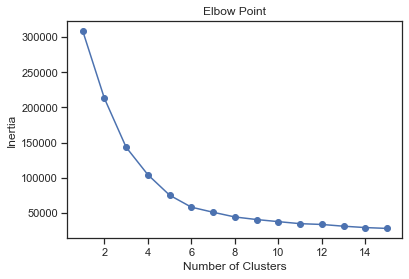

In [36]:
#Plot inertia for each numer of clusters
plt.plot(n_clusters,inertia,'bo-')
plt.ylabel('Inertia')
plt.xlabel('Number of Clusters')
plt.title('Elbow Point')
plt.savefig('kmeans_inertia')
plt.show()

Using the Elbow method, the elbow point appears to be 5 clusters, based on observing the highest negative percentage change in 'inertia2' and the plot above. The inertia decreases by default, but decreases insignificantly as the number of clusters increase after 5 clusters. 

The 5 clusters will be checked across various 2D scatter plots under each combination of variables, along with a 3D plot to combine the three key variables: Age, Score and Income. 

In [37]:
#Rename k=5 to Labels
features_k_means = features_k_means.rename(columns={5:'Labels'})

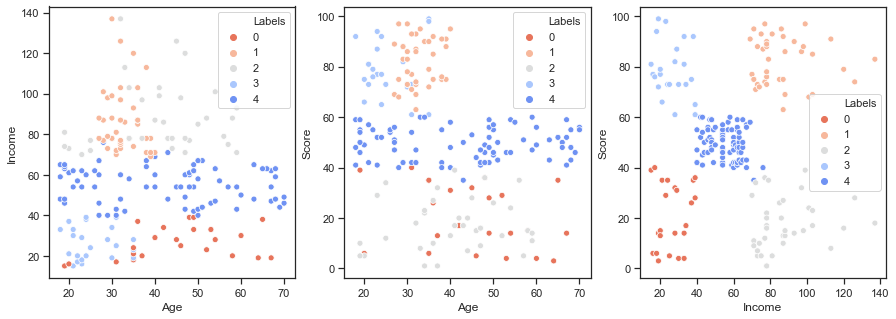

In [57]:
#Scatterplots for k = 5
fig, axes = plt.subplots(2,3, figsize=(15, 5)) 

for i in range(1,len(var_combos)+1):
    plt.subplot(1,3,i)
    sns.scatterplot(*var_combos[i-1],hue='Labels',data=features_k_means, palette=sns.color_palette('coolwarm_r',5))

plt.savefig('kmeans_scatter')
plt.show()

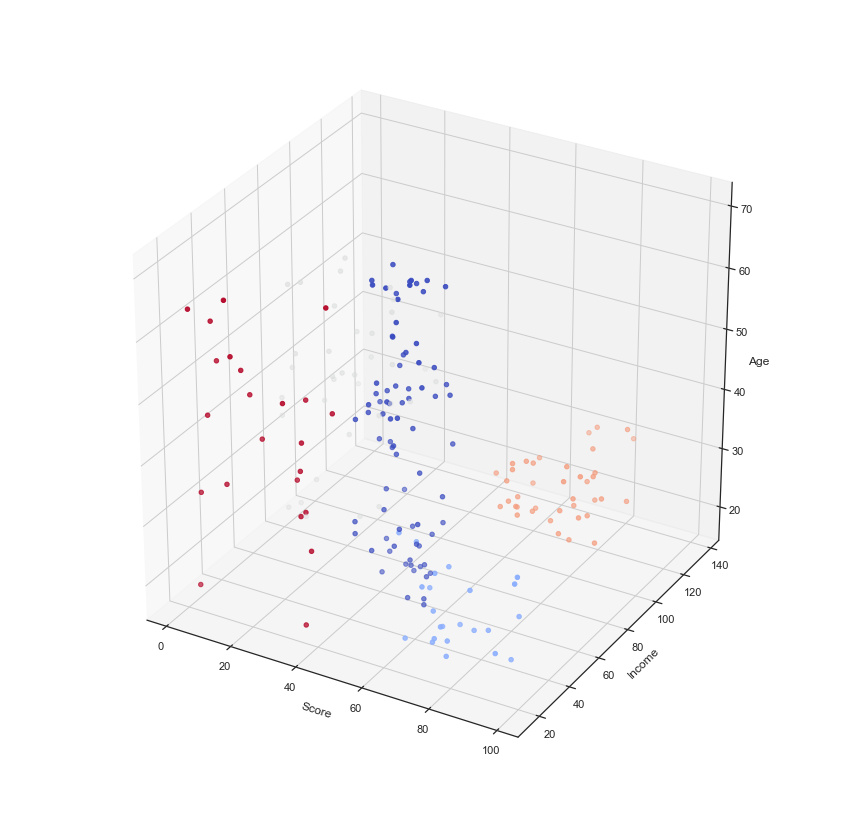

In [39]:
#K-Means 3D Plot
#%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

#Axis values
x = features_k_means['Score']
y = features_k_means['Income']
z = features_k_means['Age']

#Axis labels
ax.set_xlabel('Score')
ax.set_ylabel('Income')
ax.set_zlabel('Age')

#3D Plot
ax.scatter(x,y,z, c=features_k_means['Labels'], cmap='coolwarm_r')

#To avoid z-label get cut off
ax.dist = 11

#set size of plot
fig.set_size_inches(15, 15)

plt.savefig('kmeans_3D')
plt.show()

**K-Means Clustering shows 5 clusters:**
* Red: High Income and Spending Score, and under 40 years of age
* Orange: High Income and low Spending Score 
* Light Blue: medium Income and Spending Score 
* Blue: Low Income and high Spending Score, and under 40 years of age
* Grey: Low Income and Spending Score.

### Agglomeration Clustering

Dendrograms were built for each of the four linkage methods to be considered below. 

In [40]:
#Linkages to test
linkage = ['ward', 'complete', 'average', 'single']

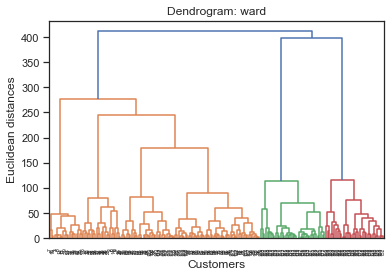

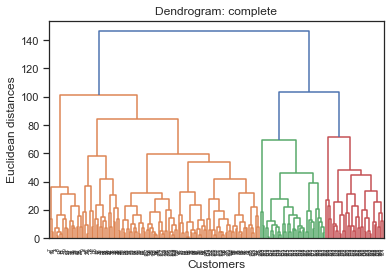

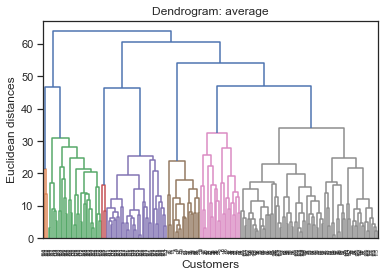

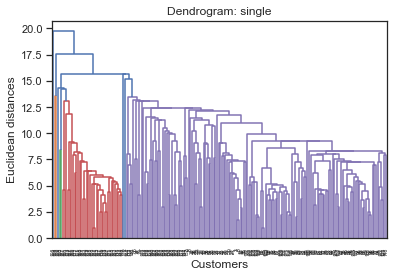

In [58]:
#Scatterplots

for i in linkage:
    dendrogram = sch.dendrogram(sch.linkage(features, method=i))
    plt.title('Dendrogram: '+i)
    plt.xlabel('Customers')
    plt.ylabel('Euclidean distances')
    plt.savefig('Dendrogram_'+i)
    plt.show()

The longest vertical distance without any horizontal line passing would help determine the number of selected clusters. From the above dendrograms, this is the most clear using the 'ward' linkage method on the right-hand side. 

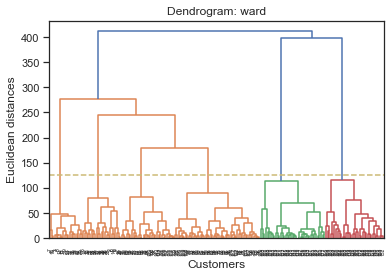

In [59]:
#Dendrogram cut-off based on the longest vertical distance without any horizontal line passing
dendrogram = sch.dendrogram(sch.linkage(features, method='ward'))
plt.title('Dendrogram: ward')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')

plt.axhline(y=125, color='y', linestyle='--')

plt.savefig('Dendrogram__Ward')
plt.show()

By observing for distances below 125 roughly, there are 6 clusters that are shown with 6 vertical lines below the distance of roughly 125. 

In [43]:
#Agglomerative Clustering
labels = []

#Agglomerative Clustering: 6 clusters, euclidean distance and ward linkage method
agg = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
agg.fit(features)
labels.append(agg.labels_)
labels = pd.DataFrame(agg.labels_)

In [44]:
#Add labels to dataframe for plotting
features_agg = features.copy()
features_agg[['Labels']] = labels
features_agg

,Age,Income,Score,Labels
0,19,15,39,4
1,21,15,81,3
2,20,16,6,4
3,23,16,77,3
4,31,17,40,4
...,...,...,...,...
195,35,120,79,2
196,45,126,28,0
197,32,126,74,2
198,32,137,18,0


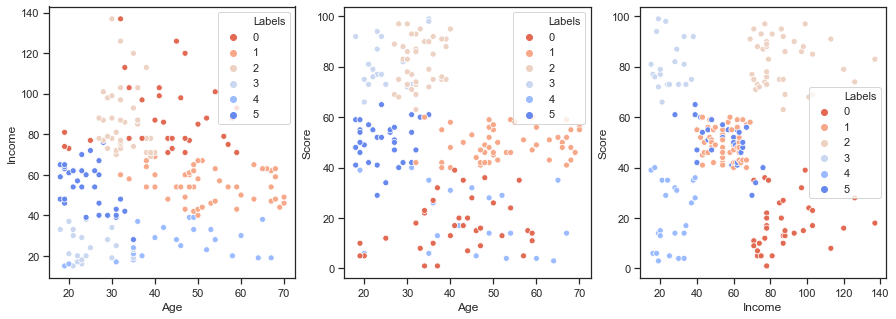

In [56]:
#Scatterplots for k = 6
fig, axes = plt.subplots(2,3, figsize=(15, 5)) 

for i in range(1,len(var_combos)+1):
    plt.subplot(1,3,i)
    sns.scatterplot(*var_combos[i-1],hue='Labels',data=features_agg, palette=sns.color_palette('coolwarm_r',6))
plt.savefig('agg_scatter')
plt.show()

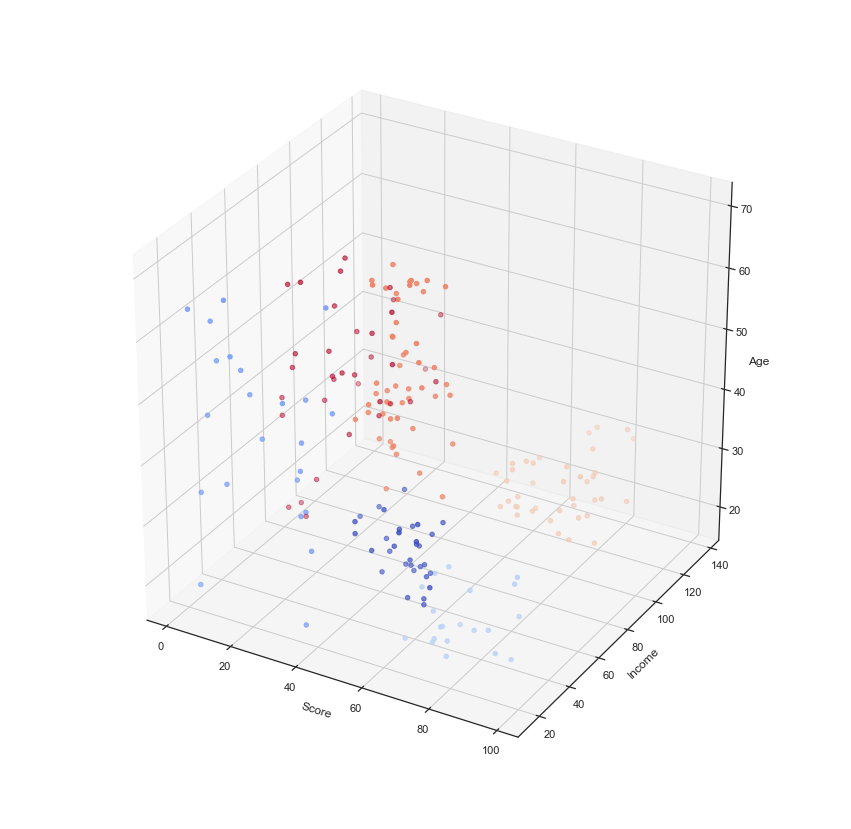

In [46]:
#Agglomerative Clustering 3D Plot
#%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

#Axis values
x = features_agg['Score']
y = features_agg['Income']
z = features_agg['Age']

#Axis labels
ax.set_xlabel('Score')
ax.set_ylabel('Income')
ax.set_zlabel('Age')

#3D Plot
ax.scatter(x,y,z, c=features_agg['Labels'], cmap='coolwarm_r')

#To avoid z-label get cut off
ax.dist = 11

#set size of plot
fig.set_size_inches(15, 15)

plt.savefig('agg_3D')
plt.show()

**Agglomerative Clustering shows 6 clusters:**

* Red: High Income, low Spending Score 
* Orange: medium Income and Spending Score, and over 30 years of Age
* Light Orange: high Income and Spending Score, and under 40 years of Age
* Light Blue: low Income, high Spending Score and under 30 years of Age
* Blue: Low Income and Spending Score
* Dark Blue: medium Income and Spending Score, and under 30 years of Age.

### DBSCAN

In [47]:
#Use NearestNeighbors to find each point's closest distance from another point. 
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features)
distances, indices = nbrs.kneighbors(features)

In [48]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

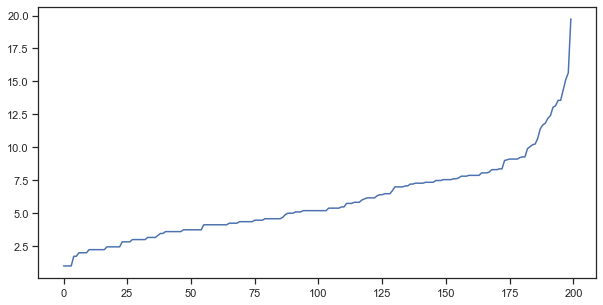

In [49]:
#Plot to find the optimal epsilon for DBSCAN
fig, axes = plt.subplots(figsize=(10, 5)) 
plt.plot(distances)

The optimal value for epsilon is be found at the point of maximum curvature.
From the above, the epsilon is 10.

In [50]:
#DBSCAN 
labels = []
features_dbscan = features.copy()

#Point of maximum curvature is when distance (eps) = 10
#Note: min_samples parameter is set as the default of 5 
dbscan = DBSCAN(eps = 10).fit(features_dbscan)
labels = dbscan.labels_
features_dbscan[['Labels']]=pd.DataFrame(labels)

In [51]:
features_dbscan

,Age,Income,Score,Labels
0,19,15,39,-1
1,21,15,81,0
2,20,16,6,-1
3,23,16,77,0
4,31,17,40,-1
...,...,...,...,...
195,35,120,79,-1
196,45,126,28,-1
197,32,126,74,-1
198,32,137,18,-1


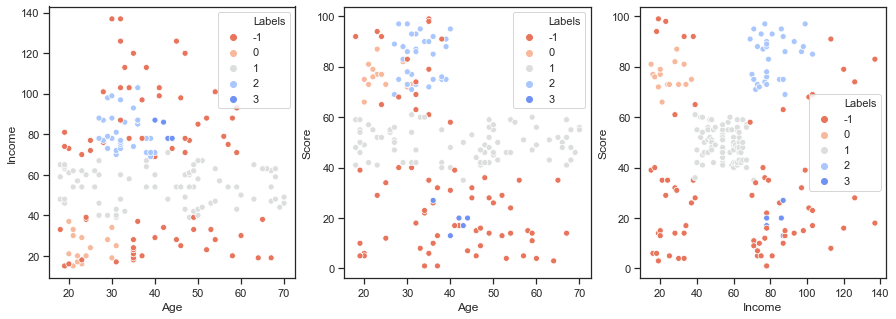

In [55]:
#Scatterplots for eps = 10
fig, axes = plt.subplots(2,3, figsize=(15, 5)) 

for i in range(1,len(var_combos)+1):
    plt.subplot(1,3,i)
    sns.scatterplot(*var_combos[i-1],hue='Labels',data=features_dbscan, 
                    palette=sns.color_palette('coolwarm_r', len(set(features_dbscan['Labels']))))
    
plt.savefig('dbscan_scatter')
plt.show()

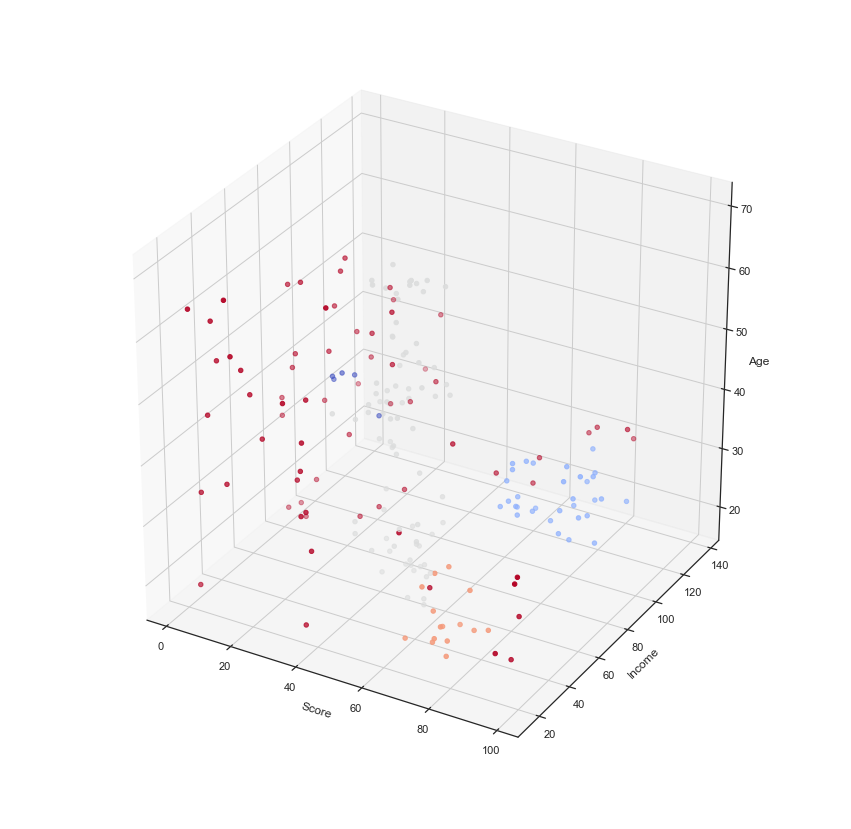

In [53]:
#DBSCAN 3D Plot
#%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

#Axis values
x = features_dbscan['Score']
y = features_dbscan['Income']
z = features_dbscan['Age']

#Axis labels
ax.set_xlabel('Score')
ax.set_ylabel('Income')
ax.set_zlabel('Age')

#3D Plot
ax.scatter(x,y,z, c=features_dbscan['Labels'], cmap='coolwarm_r')

#To avoid z-label get cut off
ax.dist = 11

#set size of plot
fig.set_size_inches(15, 15)

plt.savefig('dbscan_3D')
plt.show()

**DCSCAN shows 4 clusters:**

* Orange: Low Income, high Spending Score under 30 years of Age
* Light Blue: slightly high Income with a high Spending Score, and under 40 years of Age
* Blue: Low Spending Score, slightly higher Income and around 40 years of age
* Grey: Slightly lower Income and moderate Spending Score 
* Red: Outliers.

## Conclusion

The results of each cluster for each model are mentioned in the section above. The selected model is ultimately a matter of choosing either K-Means, Agglomerative Clustering or DBSCAN. 

Despite the different clustering results that come with selecting the model, clustering for all models have a couple of commonalities: 
* Clustering falls under the basis of Age, Spending Score and Income.  
* Each clustering model indicates common clusters following these characteristics: 
    * High Income, high Spending Score, under 40 years of Age
    * High Income, low Spending Score 
    * Low Income, high Spending Score, around the younger half of the Age distribution 
    * The models do show some form of a group roughly in moderate levels of Income and Spending Score.   

Both K-Means and Agglomerative Clustering indicate a low Income and low Spending Score cluster, while DBSCAN treats them as outliers. 

It might be speculative, but it might be a reflection that K-Means and Agglomerative Clustering do not label outliers, while DBSCAN does. 